# extraction données 

In [1]:

from datetime import datetime, timedelta
import pandas as pd
import backtrader as bt



full_df = pd.read_csv('us_banks.csv')

# Étape 1 : conversion explicite en datetime (si ce n'est pas déjà le cas)
full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')
# Étape 2 : enlever le fuseau horaire SANS conversion d'heure
# (on enlève tzinfo mais on garde l'heure locale telle quelle)
full_df['date'] = full_df['date'].apply(lambda dt: dt.replace(tzinfo=None) if pd.notna(dt) else dt)


# Étape 2: sélectionner les colonnes d'intérêt
cols = ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
full_df = full_df[cols]

# Étape 3: pivot en colonnes multiples
df_wide = full_df.pivot(index='date', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])

# Étape 4: réordonner les colonnes si tu veux (facultatif)
df_wide = df_wide.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# Étape 5: fixer l'index datetime
df_wide.index = pd.to_datetime(df_wide.index)




# ------------------------------------------------------------------
# 2) Fonctions utilitaires (identiques, mais génériques)
# ------------------------------------------------------------------
def prepare_for_backtrader(df_wide, symbol):
    """
    Extrait le sous-DataFrame df_wide[symbol] (colonnes OHLCV)
    et ajoute openinterest = 0 pour Backtrader.
    """
    df = df_wide[symbol].copy()
    required = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required):
        missing = [c for c in required if c not in df.columns]
        raise ValueError(f"{symbol} – colonnes manquantes : {missing}")
    df['openinterest'] = 0
    df = df.dropna()
    return df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]

def filter_last_days(df, n_days):
    cutoff = df.index.max() - timedelta(days=n_days)
    return df[df.index >= cutoff]


C:\Users\JEAUL2\AppData\Local\Temp\ipykernel_4224\3196832630.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')


# Backtest

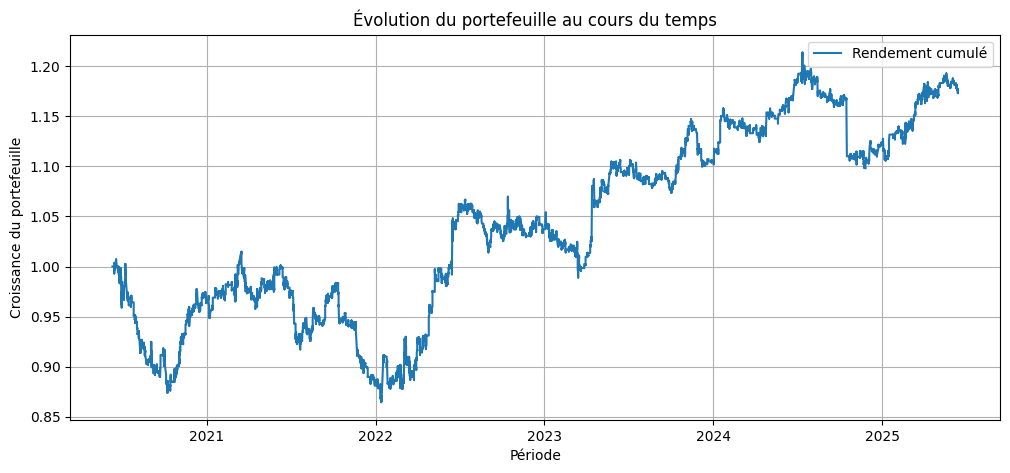

Volatilité annualisée : 0.1001
Sharpe ratio : 0.4283
Drawdown maximal : -0.1481

Fréquence des paires sélectionnées :
(MS, JPM)    1251
Name: count, dtype: int64

Nombre moyen de trades par jour : 1.01
Gain moyen : 283.4438
Perte moyenne : -270.9045
Durée moyenne des positions (h) : 0.76


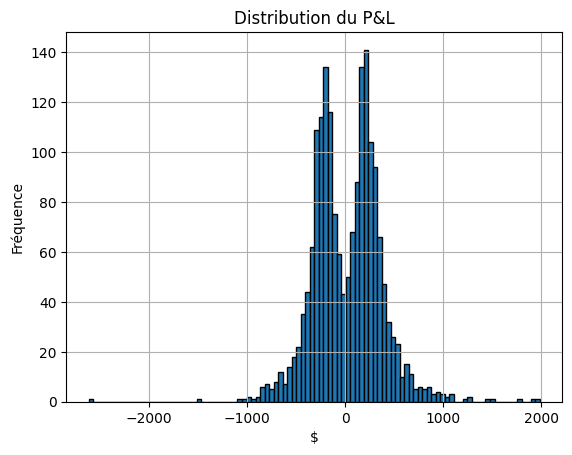

In [ ]:
from backtest import PairTradingStrategy
from dependence_modeling import *


"""
symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']
"""
"""
symbols = ['JPM', 'BAC', 'C', 'WFC',
           'GS', 'MS']
"""

symbols = ['MS', 'JPM']

# ------------------------------------------------------------------
# 3) Construction du moteur Backtrader
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

# a) ajouter chaque flux de données
for sym in symbols:
    data = prepare_for_backtrader(df_wide, sym)
    # ↓ optionnel – filtrer les 250 derniers jours, par ex.
    # data = filter_last_days(data, 250)
    feed = bt.feeds.PandasData(dataname=data, name=sym)
    cerebro.adddata(feed, name=sym)

# b) paramètre pour la stratégie
params_config = dict(
    stocks=symbols,
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    profit_target=0.0015,
    edge_buffer=6
)

cerebro.addstrategy(PairTradingStrategy, **params_config)


# ------------------------------------------------------------------
# 4) Paramètres broker et lancement
# ------------------------------------------------------------------
cerebro.broker.setcash(100_000)
cerebro.broker.setcommission(leverage=1.01, commission=0.00005)
#cerebro.broker.setcommission(commission=0.00005)  # 0.05%
#cerebro.broker.set_slippage_perc(perc=0.0002)  # 0.02%



results = cerebro.run()